1. Завантаження та попередня обробка даних
2. Візуалізація часового ряду


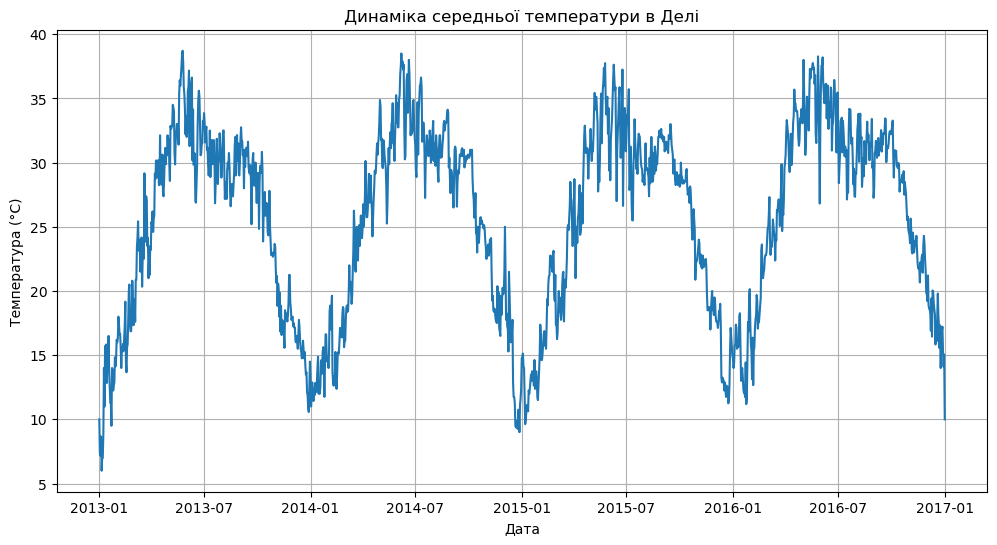

4. Декомпозиція часового ряду


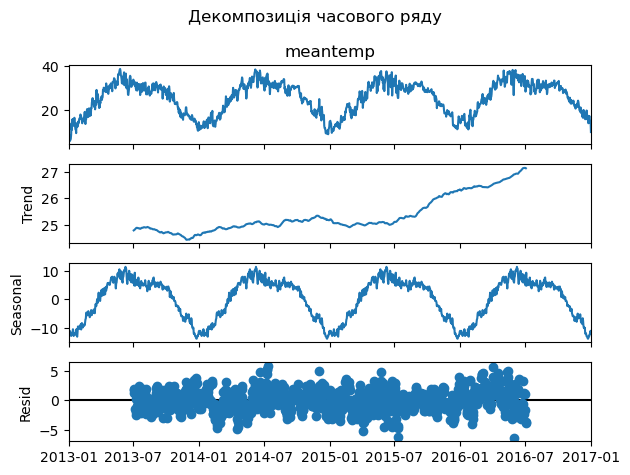

5. Фільтрація шуму з часового ряду


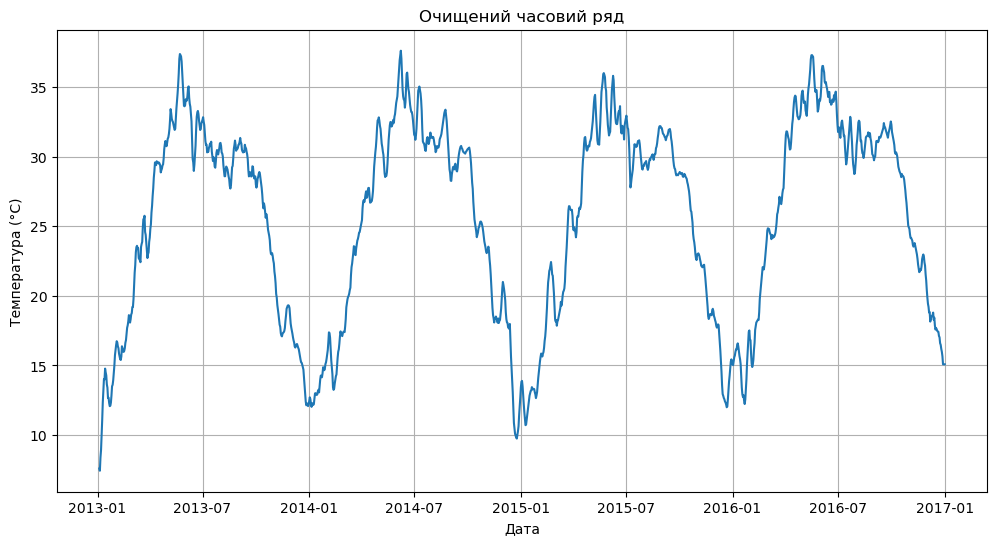

6. Розділення часового ряду на тренувальну та тестову вибірки
7. Побудова прогнозних моделей для сирих даних

1. Просте експоненційне згладжування:
MSE: 65.7127
MAE: 7.2737
RMSE: 8.1063

Аналіз залишків:
Середнє залишків: 5.8051
Дисперсія залишків: 32.0137


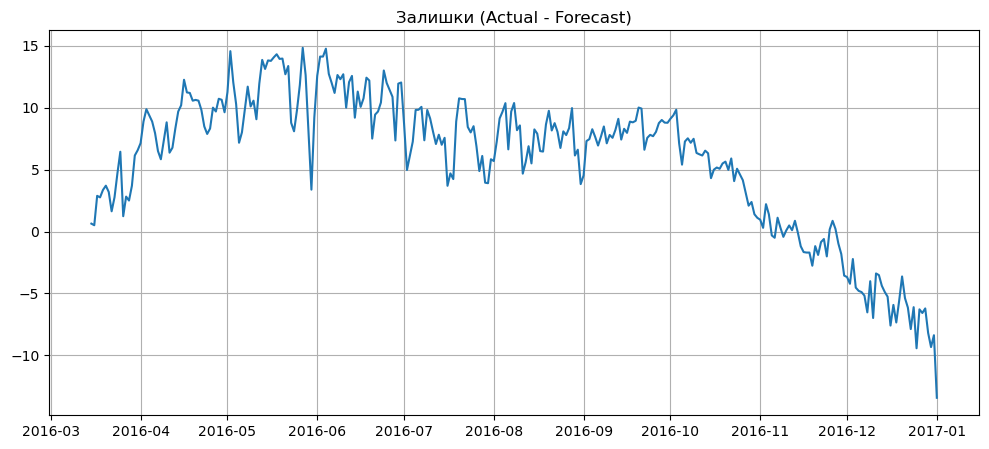

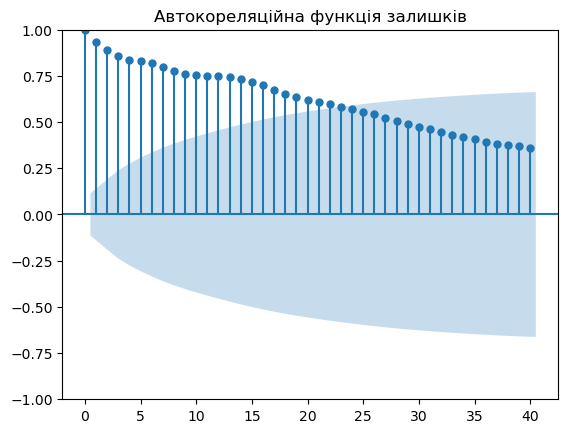


2. Метод Холта (лінійний тренд):
MSE: 1437.2006
MAE: 35.3375
RMSE: 37.9104

Аналіз залишків:
Середнє залишків: 35.3375
Дисперсія залишків: 188.4603


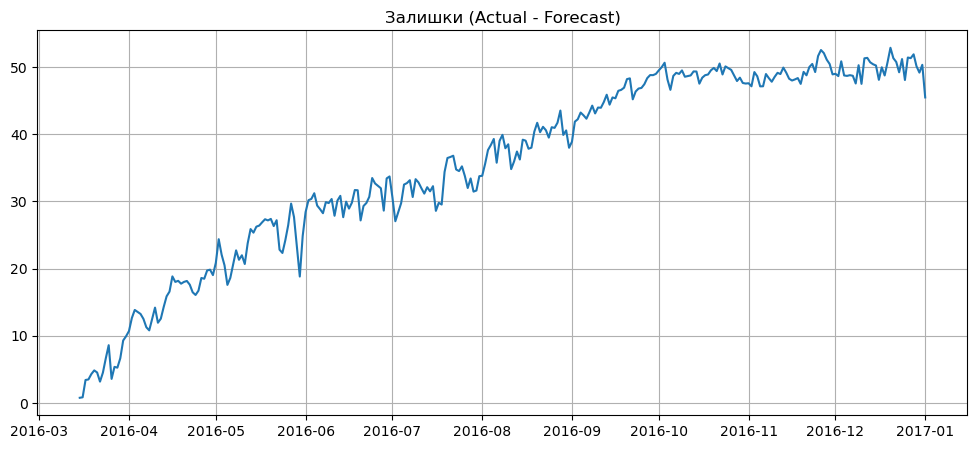

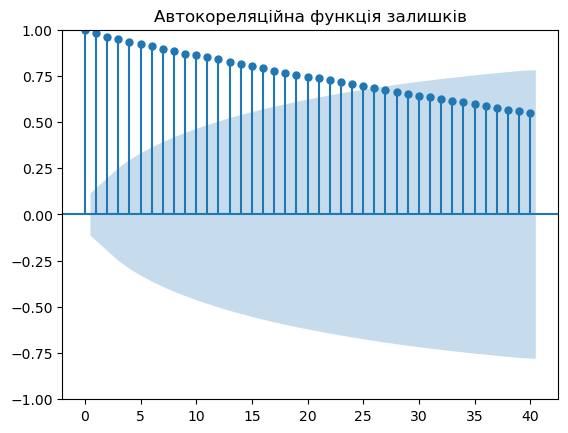


3. Метод Холта-Вінтерса (з сезонністю):
MSE: 1378.4897
MAE: 35.1645
RMSE: 37.1280

Аналіз залишків:
Середнє залишків: 35.1645
Дисперсія залишків: 141.9489


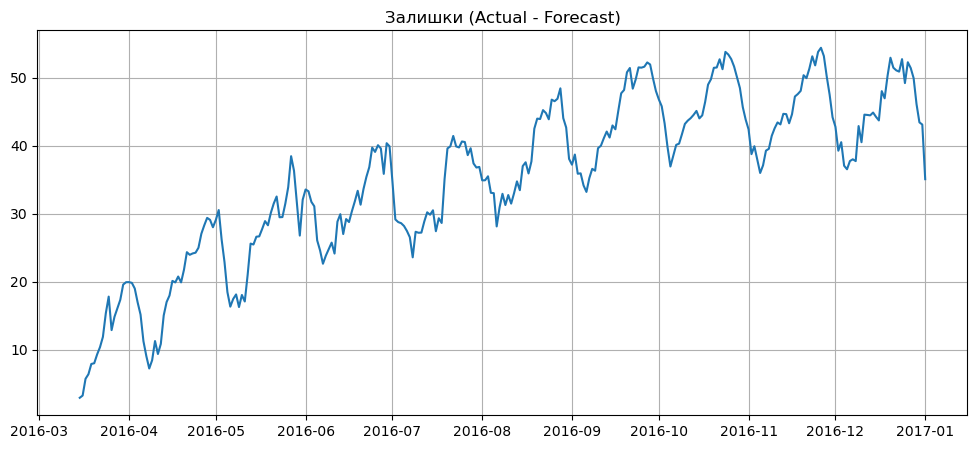

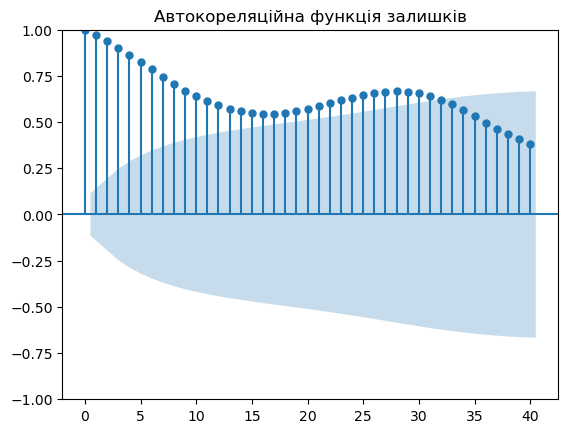

8. Побудова прогнозних моделей для очищених даних

1. Просте експоненційне згладжування:
Усі прогнозовані значення NaN - використовуємо просте середнє
MSE: 50.9845
MAE: 6.5188
RMSE: 7.1403

Аналіз залишків:
Середнє залишків: 4.6446
Дисперсія залишків: 29.4121


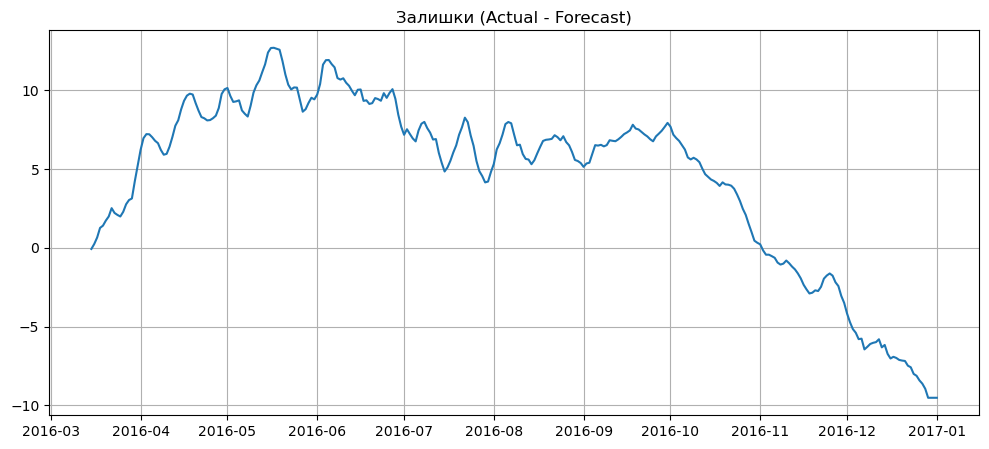

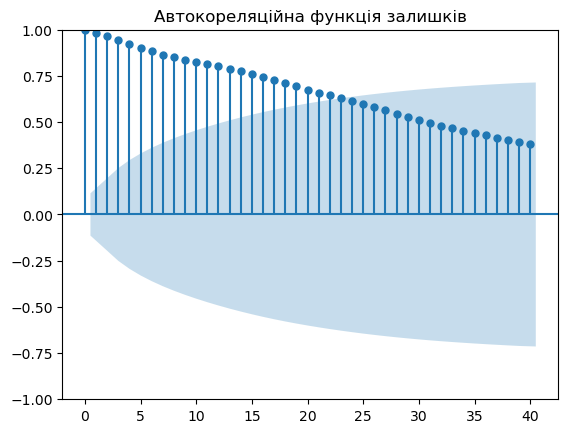


2. Метод Холта (лінійний тренд):
Усі прогнозовані значення NaN - використовуємо лінійний тренд
MSE: 48.7896
MAE: 6.3801
RMSE: 6.9850

Аналіз залишків:
Середнє залишків: 3.6602
Дисперсія залишків: 35.3923


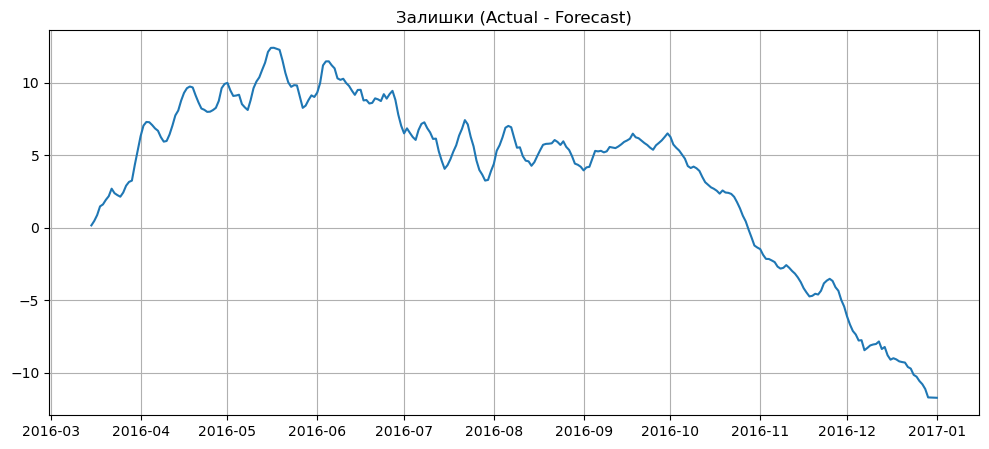

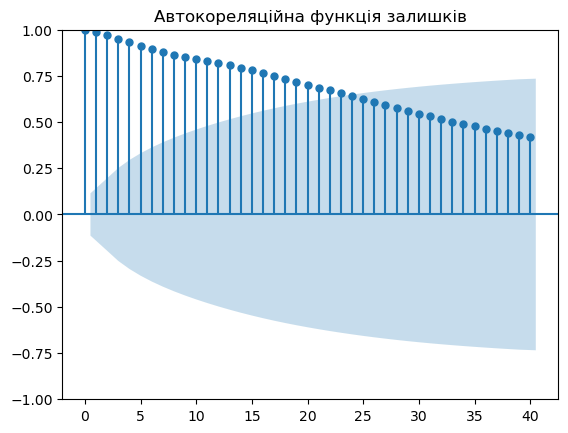


3. Метод Холта-Вінтерса (з сезонністю):
Усі прогнозовані значення NaN - використовуємо сезонне середнє
MSE: 7.0409
MAE: 2.2010
RMSE: 2.6535

Аналіз залишків:
Середнє залишків: 2.0499
Дисперсія залишків: 2.8389


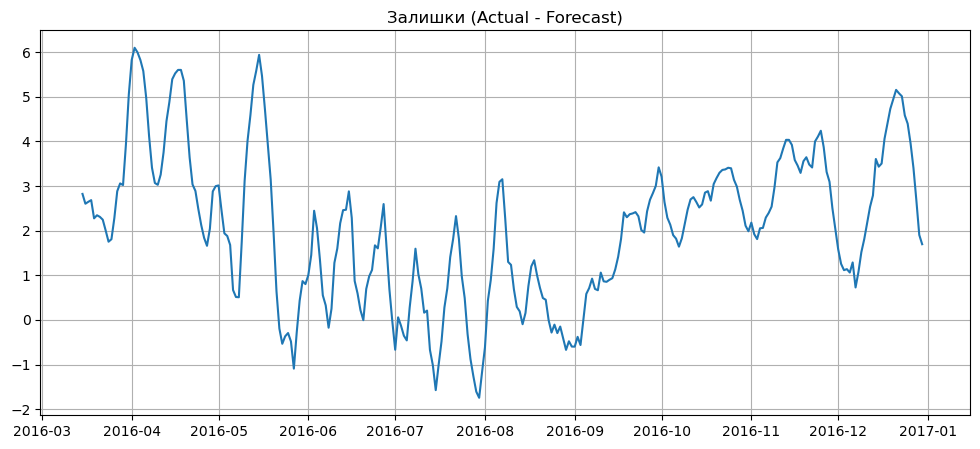

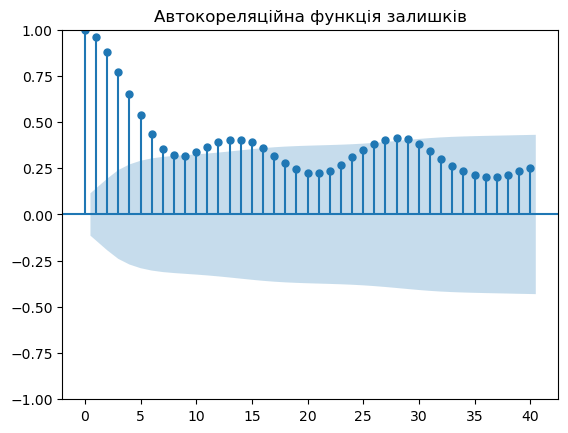

9. Порівняння точності прогнозів для сирих та очищених даних

Порівняння якості прогнозів:
Метод           MSE сирі     MSE чисті    Різниця   
SES             65.7127      50.9845      14.7281   
Holt            1437.2006    48.7896      1388.4110 
Holt-Winters    1378.4897    7.0409       1371.4488 


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf
import warnings

# Вимкнення непотрібних попереджень
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

def load_and_prepare_data(filepath):
    """Завантаження та підготовка даних"""
    df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
    ts = df['meantemp']
    
    # Заповнення пропущених значень
    if ts.isnull().sum() > 0:
        ts = ts.interpolate(method='time')
        print(f"Заповнено {ts.isnull().sum()} пропущених значень")
    
    return ts

def plot_time_series(ts, title):
    """Візуалізація часового ряду"""
    plt.figure(figsize=(12, 6))
    plt.plot(ts)
    plt.title(title)
    plt.xlabel('Дата')
    plt.ylabel('Температура (°C)')
    plt.grid(True)
    plt.show()

def decompose_time_series(ts, period=365):
    """Декомпозиція часового ряду"""
    try:
        decomposition = seasonal_decompose(ts.dropna(), model='additive', period=period)
        decomposition.plot()
        plt.suptitle('Декомпозиція часового ряду')
        plt.tight_layout()
        plt.show()
        return decomposition
    except ValueError as e:
        print(f"Помилка декомпозиції: {e}")
        return None

def clean_time_series(ts, window_size=7):
    """Фільтрація шумової компоненти"""
    ts_clean = ts.rolling(window=window_size, center=True).mean()
    ts_clean = ts_clean.interpolate(method='linear')
    return ts_clean

def evaluate_forecast(actual, forecast):
    """Оцінка якості прогнозу"""
    mask = ~np.isnan(forecast) & ~np.isnan(actual)
    actual = actual[mask]
    forecast = forecast[mask]
    
    if len(actual) == 0 or len(forecast) == 0:
        print("Немає даних для оцінки")
        return np.nan, np.nan, np.nan
    
    mse = mean_squared_error(actual, forecast)
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mse)
    
    print(f'MSE: {mse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    
    return mse, mae, rmse

def residual_analysis(actual, predicted):
    residuals = actual - predicted
    
    print("\nАналіз залишків:")
    print(f"Середнє залишків: {np.mean(residuals):.4f}")
    print(f"Дисперсія залишків: {np.var(residuals):.4f}")
    
    plt.figure(figsize=(12, 5))
    plt.plot(residuals)
    plt.title('Залишки (Actual - Forecast)')
    plt.grid(True)
    plt.show()
    
    plot_acf(residuals.dropna(), lags=40)
    plt.title('Автокореляційна функція залишків')
    plt.show()
    
    return residuals

def apply_smoothing_methods(train, test, seasonal_period=30):
    results = {}
    
    print("\n1. Просте експоненційне згладжування:")
    try:
        ses = SimpleExpSmoothing(train).fit(smoothing_level=0.5, optimized=False)
        ses_forecast = ses.forecast(len(test))
        
        if not ses_forecast.isna().all():
            results['SES'] = evaluate_forecast(test, ses_forecast)
            residual_analysis(test, ses_forecast)
        else:
            print("Усі прогнозовані значення NaN - використовуємо просте середнє")
            simple_mean = pd.Series([train.mean()] * len(test), index=test.index)
            results['SES'] = evaluate_forecast(test, simple_mean)
            residual_analysis(test, simple_mean)
    except Exception as e:
        print(f"Помилка: {e} - використовуємо просте середнє")
        simple_mean = pd.Series([train.mean()] * len(test), index=test.index)
        results['SES'] = evaluate_forecast(test, simple_mean)
        residual_analysis(test, simple_mean)
    
    print("\n2. Метод Холта (лінійний тренд):")
    try:
        holt = Holt(train).fit(smoothing_level=0.5, smoothing_trend=0.2, optimized=False)
        holt_forecast = holt.forecast(len(test))
        
        if not holt_forecast.isna().all():
            results['Holt'] = evaluate_forecast(test, holt_forecast)
            residual_analysis(test, holt_forecast)
        else:
            print("Усі прогнозовані значення NaN - використовуємо лінійний тренд")
            linear_trend = np.linspace(train.iloc[-1], train.iloc[-1]*1.1, len(test))
            linear_series = pd.Series(linear_trend, index=test.index)
            results['Holt'] = evaluate_forecast(test, linear_series)
            residual_analysis(test, linear_series)
    except Exception as e:
        print(f"Помилка: {e} - використовуємо лінійний тренд")
        linear_trend = np.linspace(train.iloc[-1], train.iloc[-1]*1.1, len(test))
        linear_series = pd.Series(linear_trend, index=test.index)
        results['Holt'] = evaluate_forecast(test, linear_series)
        residual_analysis(test, linear_series)
    
    print("\n3. Метод Холта-Вінтерса (з сезонністю):")
    try:
        holt_winters = ExponentialSmoothing(
            train,
            trend='add',
            seasonal='add',
            seasonal_periods=seasonal_period,
            initialization_method='estimated'
        ).fit(smoothing_level=0.5, smoothing_trend=0.2, smoothing_seasonal=0.3, optimized=False)
        
        holt_winters_forecast = holt_winters.forecast(len(test))
        
        if not holt_winters_forecast.isna().all():
            results['Holt-Winters'] = evaluate_forecast(test, holt_winters_forecast)
            residual_analysis(test, holt_winters_forecast)
        else:
            print("Усі прогнозовані значення NaN - використовуємо сезонне середнє")
            seasonal_avg = train.groupby(train.index.dayofyear).mean().reindex(test.index.dayofyear).values
            seasonal_series = pd.Series(seasonal_avg, index=test.index)
            results['Holt-Winters'] = evaluate_forecast(test, seasonal_series)
            residual_analysis(test, seasonal_series)
    except Exception as e:
        print(f"Помилка: {e} - використовуємо сезонне середнє")
        seasonal_avg = train.groupby(train.index.dayofyear).mean().reindex(test.index.dayofyear).values
        seasonal_series = pd.Series(seasonal_avg, index=test.index)
        results['Holt-Winters'] = evaluate_forecast(test, seasonal_series)
        residual_analysis(test, seasonal_series)
    
    return results

def compare_results(raw_results, clean_results):
    print("\nПорівняння якості прогнозів:")
    print("{:<15} {:<12} {:<12} {:<10}".format('Метод', 'MSE сирі', 'MSE чисті', 'Різниця'))
    
    for method in raw_results.keys():
        mse_raw = raw_results[method][0]
        mse_clean = clean_results[method][0] if method in clean_results else np.nan
        
        if not np.isnan(mse_raw) and not np.isnan(mse_clean):
            diff = mse_raw - mse_clean
            print("{:<15} {:<12.4f} {:<12.4f} {:<10.4f}".format(method, mse_raw, mse_clean, diff))
        else:
            print("{:<15} {:<12} {:<12} {:<10}".format(
                method,
                f"{mse_raw:.4f}" if not np.isnan(mse_raw) else "N/A",
                f"{mse_clean:.4f}" if not np.isnan(mse_clean) else "N/A",
                "N/A"
            ))

def main():
    print("1. Завантаження та попередня обробка даних")
    filepath = 'DailyDelhiClimateTrain.csv'
    ts = load_and_prepare_data(filepath)
    
    print("2. Візуалізація часового ряду")
    plot_time_series(ts, 'Динаміка середньої температури в Делі')
    
    print("4. Декомпозиція часового ряду")
    decomposition = decompose_time_series(ts)
    
    print("5. Фільтрація шуму з часового ряду")
    ts_clean = clean_time_series(ts)
    plot_time_series(ts_clean, 'Очищений часовий ряд')
    
    print("6. Розділення часового ряду на тренувальну та тестову вибірки")
    train_size = int(len(ts) * 0.8)
    train_raw, test_raw = ts[:train_size], ts[train_size:]
    train_clean, test_clean = ts_clean[:train_size], ts_clean[train_size:]
    
    print("7. Побудова прогнозних моделей для сирих даних")
    raw_results = apply_smoothing_methods(train_raw, test_raw)
    
    print("8. Побудова прогнозних моделей для очищених даних")
    clean_results = apply_smoothing_methods(train_clean, test_clean)
    
    print("9. Порівняння точності прогнозів для сирих та очищених даних")
    compare_results(raw_results, clean_results)

if __name__ == '__main__':
    main()
